In [1]:
import cv2
import numpy as np
import datetime
from matplotlib import pyplot as plt
import time
print(cv2.__version__)

4.5.1


[1, 281, 216, 160, 70]


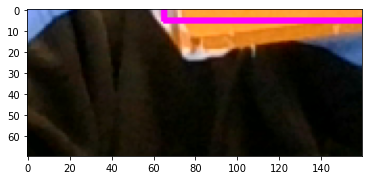

In [2]:
cap = cv2.VideoCapture(0)
whT = 320

confThreshold = 0.5
nmsThreshold = 0.3
a = [0,0,0,0,0]
x,y,w,h = 0,0,0,0
ED = True
classesFile = 'obj.names'
classNames = []

with open(classesFile, 'rt') as f:
    classNames = f.read().rstrip('\n').split('\n')
    
#print(classNames)
#print(len(classNames))

modelConfiguration= 'yolov3_ED.cfg'
modelWeights= 'yolov3_best.weights'

net = cv2.dnn.readNetFromDarknet(modelConfiguration,modelWeights)
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)
net.setPreferableTarget(cv2.dnn.DNN_TARGET_CPU)

def findObjects(outputs,img):
    hT, wT, cT, = img.shape
    bbox= []
    classIds = []
    confs = []
 #   now = datetime.datetime.now().strftime("%d_%H_%M_%S")
 #   frame= cap.read()
    
    for output in outputs:
        for det in output:
            scores = det[5:]
            classId= np.argmax(scores)
            confidence = scores[classId]
            if confidence > confThreshold:
                w,h = int(det[2]*wT), int(det[3]*hT)
                x,y = int((det[0]*wT)-w/2), int((det[1]*hT)-h/2)
                bbox.append([x,y,w,h])
                classIds.append(classId)
                confs.append(float(confidence))
    #print(len(bbox))
    indices = cv2.dnn.NMSBoxes(bbox,confs,confThreshold,nmsThreshold)
    #print(indices)
    for i in indices:
        i = i[0]
        box = bbox[i]
        x,y,w,h = box[0],box[1],box[2],box[3]
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,255),2)
        cv2.putText(img,f'{classNames[classIds[i]].upper()} {int(confs[i]*100)}%', (x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.6,(255,0,255),2)
        #ED_pic = frame[x:x+h, y:y+w]
       # plt.imshow(ED_pic)
       # plt.show
       
        #print(classNames[classIds[i]].upper())
        if indices == [[0]]:
            ED = False
            a[0] = 1
            a[1] = x
            a[2] = y
            a[3] = w
            a[4] = h
            break
            


def Main():
    while True:
        success, img = cap.read()

        blob = cv2.dnn.blobFromImage(img,1/255,(whT,whT),[0,0,0],1,crop=False)
        net.setInput(blob)

        layerNames = net.getLayerNames()
       # print(layerNames)
        outputNames = [layerNames[i[0]-1] for i in net.getUnconnectedOutLayers()]
        #print(outputNames) 
       # print(net.getUnconnectedOutLayers())

        outputs = net.forward(outputNames)
        #print(outputs[0].shape)
        #print(outputs[1].shape)
        #print(outputs[2].shape)
        #print(outputs[0][0])

        findObjects(outputs,img)
        
        if a[0] == 1:
            ret,frame = cap.read()
            ED_pic = img[a[1]:a[1]+a[4], a[2]:a[2]+a[3]]
            plt.imshow(ED_pic)
            plt.show            
            print(a)
            break
            
    

    #     if not ED:
    #         ret,frame = cap.read()
    #         ED_pic = img[x:x+h, y:y+w]
    #         plt.imshow(ED_pic)
    #         plt.show
    #         ret,frame = cap.read()
    #         ED_pic = img[x:x+h, y:y+w]
    #         plt.imshow(ED_pic)
    #         plt.show
    #         break
        cv2.imshow('Img',img)
        cv2.waitKey(1)
        
Main()

# 